# 1D aproximace "libovolné" funkce pomocí MKP
<small> Tento výukový text je inspirován **Finite and Spectral Element Methods Using Matlab** (C. Pozrikidis),
**The Finite Element Method using Matlab** (Y. W. Kwon) a fenomenálním tutoriálem prof. H.P. Langtangena (https://github.com/hplgit). Kód je psán ve volně dostupném jazyce Python 2.7 +(https://www.python.org/) s využitím volně dostupných third-party knihoven a interaktivní konzole Jupyter (http://jupyter.org/). <small>

In [20]:
import numpy as np
import sympy as sp
import matplotlib.pylab as plt
%matplotlib inline
import scipy.integrate as sc
from tqdm import tnrange
from scipy import sparse
plt.xkcd()

## Uniformní síť

V první řádě vytvořme 1D síť, která bude uniformní (tedy vzdálenost bodů bude vždy stejná). Síť bude reprezentována dvěma poli: 
\begin{itemize}
    \item \textbf{vertices}: pole, které obsahuje souřadnice každého uzlu tj. $x_{0}$, $x_{1}$, ... $x_{n}$
    \item \textbf{cells}: pole, které obsahuje vždy dva indexy uzlu, které tvoří prvek tj. $cell^{0}[0, 1]$, $cell^{1}[1, 2]$, ..., $cell^{N_e}[n-1, n]$. Musíme zachovat spojitost na rozhranní prvku
\end{itemize}
Vstupními argumenty bude počet elementů **N_e** a list(pole) **Omega** s intervalem sítě:

In [2]:
def mesh_uniform(N_e=5, Omega=[0, 1]):
    '''Return a uniform mesh represented by vertices and cell'''
    vertices = np.linspace(Omega[0], Omega[1], N_e + 1) # vytvor pole uzlu pro N_e + 1
    cells = [[e, e + 1] for e in range(N_e)] # smycka pres elementy
    return np.asarray(vertices), np.asarray(cells)
print 'pole uzlů: {}'.format(mesh_uniform()[0])
print 'pole prvků: {}'.format(mesh_uniform()[1])

pole uzlů: [ 0.   0.2  0.4  0.6  0.8  1. ]
pole prvků: [[0 1]
 [1 2]
 [2 3]
 [3 4]
 [4 5]]


## Lokální-globální mapování indexů stupňů volnosti

Pro každý lokální index uzlu(stupně volnosti) musí existovat jednoznačný globální index, který potřebujeme ke složení celkové matice A, tedy $I_{loc}->I_{glob}$. Musí platit, že pro $d=1$ vrací funkce \textbf{dofmap} stejné pole jako pole $cell$. V ostaních případech pro d=>1 musí platit:
$$dofmap_{e}^{d} = [e \cdot d + 1, e \cdot d + 2,..., e \cdot d + d + 1]
$$
Vstupnímy parametry je opět \textbf{N_e} a \textbf{d} - řád aproximace

In [3]:
def dofmap(N_e=5, d=0):
    '''Return a phi vector and corresponding dof_map array'''
    if d == 0: # Pokud je d==0 pak prirad stupne volnosti k prvnimu uzlu elementu, tedy [0], [1], [2]...[N_e]
        dof_map = [[e] for e in range(N_e)]
    else:
        dof_map = [[e * d + i for i in range(d + 1)] for e in range(N_e)]
    return np.asarray(dof_map)
print dofmap()

[[0]
 [1]
 [2]
 [3]
 [4]]


## Generátor Lagrangeových polynomů v d + 1 interpolačních bodech

Pro vytvoření d + 1 interpolačních polynomů Lagrangeova typu na referenčním intervalu [-1, 1] známe z minulého kódu..okopírujeme...:-)

In [4]:
def Lagrange_polynomial(x, i, points):
    '''vygeneruj itou Lagrangeovu polynomickou funkci 
    v interpolacnich bodech z pole points.
    '''
    p = 1
    for j in range(len(points)):
        if j != i:
            p *= (x - points[j]) / (points[i] - points[j])
    return p
def phi_r(r, X, d):
    points = np.linspace(-1, 1, d + 1)  
    return Lagrange_polynomial(X, r, points)
def basis(d=1): 
    X = sp.Symbol('X')
    phi = [phi_r(r, X, d) for r in range(d + 1)]
    return phi  
sp.pprint(basis())

[-0.5⋅X + 0.5, 0.5⋅X + 0.5]


## Afinní transformace z fyzikálních do referenčních souřadnic

Využitím transformace řešení z fyzikálního elementu do elementu referečního získáme snadnou formulaci tvarových funkcí, které jsou stejné pro všechny elementy. Využijme jednoduché lineární transformace předepsané Lagrangeovým polynomem I. řádu:
$$
    x^{e} = \frac{1}{2}(x_{\Omega_L} + x_{\Omega_R})+\frac{1}{2}(x_{\Omega_R} - x_{\Omega_L})X
$$ kde $x^{e}$ jsou fyzikální souřadnice elementu, X souřadnice referenčního elementu a $x_{\Omega_L}, x_{\Omega_R}$ jsou intervaly(left, right) e-tého elementu. Napišme funkci, která přijme referenční interval \textbf{X} souřadnici a fyzikální interval daného elementu \textbf{Omega_e} a vrátí fyzikální souřadnici $x^{e}$.

In [5]:
def affine_mapping(X=0, Omega_e=[0.5, 1.5]):
    '''Transformace referencnich souradnic do fyzikalnich souradnic elementu na Omega_e'''
    x_L, x_R = Omega_e
    return 0.5*(x_L + x_R) + 0.5*(x_R - x_L)*X
print affine_mapping()

1.0


## Složení celkové matice A a vektoru pravé strany b

Ústřední částí MKP je kód pro řádné složení lokálních matic elementu \textbf[A_e] a vektoru pravé strany \textbf{b_e} do jedné globální matice \textbf{A} a vektoru \textbf{b}. Pro zachování interprvkové konektivity (spojitosti) hlavní smyčka přes elementy \textbf{N_e} obsahuje sčítání dílčích matic \textbf{A_e} do \textbf{A} následující vztah:
$$A_{dofmap[e, r], dofmap[e, s]}+=A_e[r, s]$$
$$b_{dofmap[e, r]}+=b_e[r]$$
kde \textbf{dofmap} je pole, které vrací pro daný element $e$ globální čísla stupňů volnosti, který daný prvek obsahuje. Indexy $r, s$ jsou lokální indexy elementu (stejné pro všechny elementy). Napište funkci, která přijme pole \textbf{vertices}, \textbf{cells}, \textbf{dof_map}, pole tvarových funkcí \textbf{phi}, aproximovanou funkci \textbf{f} a kvadraturní body \textbf{xp} a přidružené váhové koeficienty \textbf{wp}. Vzhledem k tomu, že výpočet dílčí matice A_e je z velké části stejný pro všechny elementy (jenom jakobián transformace se liší), tak ji přesuneme dovnitř této funkce.

In [6]:
def assemble(vertices, cells, dof_map, phi, f, wp, xp, silent=False):
    
    # Some variable initialization
    N_n = len(list(set(dof_map.ravel()))) # Number of DOFs
    N_e = len(cells) # Number of elements
    A = np.zeros((N_n, N_n)) 
    b = np.zeros(N_n)
    n = len(phi)
    phi_n = np.zeros((n, len(wp)))
    X = sp.Symbol('X')
    
    # Evaluate basis function at GLL points
    for i, iphi in enumerate(phi):
        phi_n[i] = sp.lambdify([X], iphi)(xp)
    
    # some pre-computed part of Ae
    A_pre = np.zeros((n, n))
    for r in range(n):
        for s in range(r, n):
            A_pre[r, s] = np.sum(phi_n[r] * phi_n[s] * wp) # numerical integrate
            A_pre[s,r] = A_pre[r,s]
    
    # Start looping over elements and build final matrix A and right side vector b
            
    if silent: # Don't want to see the progressbar?
        for e in range(N_e):
            Omega_e = [vertices[cells[e, 0]], vertices[cells[e, 1]]] # Find element interval
            A_e = element_matrix(A_pre, Omega_e) # Compute element matrix of phi product A_e
            b_e = element_vector(f, phi_n, Omega_e, wp, xp) # Compute elementary right hand vector b_e 
            # looping over local indexes
            for r in range(len(dof_map[e])):
                for s in range(len(dof_map[e])):
                    A[dof_map[e, r], dof_map[e, s]] += A_e[r, s]
                b[dof_map[e, r]] += b_e[r]
    else:
        for e in tnrange(N_e, desc='Assembling'):
            Omega_e = [vertices[cells[e, 0]], vertices[cells[e, 1]]] # Find element interval
            A_e = element_matrix(A_pre, Omega_e) # Compute element matrix of phi product A_e
            b_e = element_vector(f, phi_n, Omega_e, wp, xp) # Compute elementary right hand vector b_e 
            # looping over local indexes
            for r in range(len(dof_map[e])):
                for s in range(len(dof_map[e])):
                    A[dof_map[e, r], dof_map[e, s]] += A_e[r, s]
                b[dof_map[e, r]] += b_e[r]
    return A, b
                

## Složení elementární matice bilineární formy na ref. elementu

Matice A_e obsahuje skalární součin jednotlivých tvarových funkcí $\phi_{s}$:
$$A^{e}_{r, s} = \int_{\Omega_{ref}}\phi_{r}(X)\phi_{s}(X)\frac{h_{e}}{2}dX$$, při použití numerické kvadratury:
$$
A^{e}_{r, s} = \sum_{k=0}^{d + 1}\phi_{r}(Xp_{k})\phi_{s}(Xp_{k})\frac{h_{e}}{2}wp_{k}
$$
kde $h$ je délka elementu (jacobian transformace je detJ=0.5h), $xp$ je pole integračních bodů, $wp$ je pole váhových koeficientů. Nutno podotknout, že výpočet skalárního součinu je proveden jen jednou přímo v těle funkce \textbf{assembly()}. Napišme funkci, která tedy přijme předpočítanou matici \textbf{A_pre[d+1, d+1]} a interval daného prvku \textbf{Omega_e} a vrátí elementární matici \textbf{A_e}

In [7]:
def element_matrix(A_pre, Omega_e):
    detJ = (Omega_e[1] - Omega_e[0]) / 2.
    return A_pre * detJ

## Složení elementárního vektoru pravé strany na ref. elementu

Sestavení vektoru pravé strany vyžaduje výpočet na elementární úrovni, protože funkce $f(x)$, která je definována na fyzikálním intervalu $\Omega$ musí být transformována do referenčního intervalu [-1, 1], tedy potřebujeme transformaci \textbf{affine_mapping()}. Za argument $x$ funkce $f(x)$ dosadíme vztah pro $x(X)$ získáme tranformovanou funkci $f(X)$. Nyní spočítáme skalární součin podle definice Galerkinovy projekce:
$$
b^{e}_{r} = \int_{\Omega_{ref}}\phi_{r}(X)f(X)\frac{h_{e}}{2}dX
$$, numericky potom:
$$
b^{e}_{r} = \sum_{k=0}^{d + 1}\phi_{r}(Xp_{k})f(Xp_{k})\frac{h_{e}}{2}wp_{k}
$$ Napišme tedy funkci, která přijme funkci \textbf{f}, \textbf{phi_n}, interval daného elementu \textbf{Omega_e} a kvadraturní informace \textbf{xp, wp}. Pole tvarových funkcí obsahuje hodnoty funkcí $\phi$ v integračních bodech Xp. Funkce vrací vektor \textbf{b_e[d + 1]}.

In [8]:
def element_vector(f, phi_n, Omega_e, wp, xp):
    n = len(phi_n)
    b_e = np.zeros(n)
    X = sp.Symbol('X')
    h = Omega_e[1] - Omega_e[0]
    x = affine_mapping(X, Omega_e)
    detJ = h / 2.
    f = f.subs('x', x)
    f_n = sp.lambdify(X, f)(xp)
    for r in range(n):
        b_e[r] = np.sum(f_n * phi_n[r] * wp) * detJ
    return b_e    

## Řešení soustavy rovnic Ax = b

Vzhledem k tomu, že aproximované řešení je $$U(x)=\sum_{l = 0}^{d + 1}c_{l}\phi_{l}$$ a víme, že $\phi_{i}(x_{j})=\delta_{ij}$
Potom řešení soustavy rovnic Ac=b pro c je vlastně řešení U=c. Tuto soustavu rovnic, vzhledem k tomu, že se jedná o řídkou soustavu řešme například iteračně pomocí metody $sdružených\ gradientů$ v knihovně scipy.sparse.linalg.cg. Pro vyšší řády $d$ interpolace raději snižme $tol$ řešiče na 1e-25.

In [9]:
def linearsolver(A, b):
    """Compute sparse linear system by conjugate gradient"""
    A_sp = np.asarray(A.tolist(), dtype=np.float)
    b_sp = np.asarray(b.tolist(), dtype=np.float)
    A_sp = sparse.csr_matrix(A_sp)
    return sparse.linalg.cg(A_sp, b_sp, tol=1e-25)[0]

## Úplná rekonstrukce řešení u(x) z U

Řešení $U$ je uzlové řešení, můžeme ho snadno zobrazit pokud známe odpovídající uzly \textbf{nodes} (neznáme!), známe jen pole \textbf{vertices}, které ale neobsahuje pro vyšší řády $d > 1$ i další body (interpolační vnitřní body). Pokud však chceme řešení nalézt na elementu, musíme zpětně zrekonstruovat $u^{e}(X)$:
$$
u^{e}(X) = \sum_{r=0}^{d + 1}U_{dofmap[e, r]}\phi_{r}(X)
$$
Tím získáme řešení na každém elementu a zbývá pro vykreslení spočítat pro každý element fyzikální souřadnice x^{e}:
$$
x^{e} = affinetransform(X, \Omega_{e})
$$
Nutno podotknout, že vektor ref. souřadnic $X$ je dán jako \textbf{linspace(-1, 1, res)}, kde res - rozlišení na elementu - tedy počet vykreslených bodů v rámci elementu.

In [10]:
def u_glob(U, cells, vertices, dof_map, phi, resolution_per_element=51, silent=False):
    """
    Compute (x, y) coordinates of a curve y = u(x), where u is a
    finite element function: u(x) = sum_i of U_i*phi_i(x).
    (The solution of the linear system is in U.)
    Method: Run through each element and compute curve coordinates
    over the element.
    This function works with cells, vertices, and dof_map.
    """
    x_patches = []
    u_patches = []
    N_e = len(cells)
    X = sp.Symbol('X')
    d = len(phi) - 1
    phi_ = []
    for i, iphi in enumerate(phi):
        phi_.append(sp.lambdify([X], iphi))
    X = np.linspace(-1, 1, resolution_per_element)
    Xn = np.linspace(-1, 1, d + 1)
    nodes = {}  # node coordinates (use dict to avoid multiple values)
    if silent:
        for e in range(N_e):
            Omega_e = (vertices[cells[e][0]], vertices[cells[e][-1]])
            x = affine_mapping(X, Omega_e)
            x_patches.append(x)
            u_cell = 0  # u(x) over this cell
            for r in range(d + 1):
                if d==0:
                    phirX = np.ones(len(X))
                else:
                    phirX = phi_[r](X)
                i = dof_map[e][r]  # global dof number
                u_cell += U[i] * phirX
            u_patches.append(u_cell)
            # Compute global coordinates of local nodes,
            # assuming all dofs corresponds to values at nodes
            xn = affine_mapping(Xn, Omega_e)
            for r in range(d + 1):
                nodes[dof_map[e][r]] = xn[r]
    else:
        for e in tnrange(N_e, desc='Solution recovering'):
            Omega_e = (vertices[cells[e][0]], vertices[cells[e][-1]])
            x = affine_mapping(X, Omega_e)
            x_patches.append(x)
            u_cell = 0  # u(x) over this cell
            for r in range(d + 1):
                if d==0:
                    phirX = np.ones(len(X))
                else:
                    phirX = phi_[r](X)
                i = dof_map[e][r]  # global dof number
                u_cell += U[i] * phirX
            u_patches.append(u_cell)
            # Compute global coordinates of local nodes,
            # assuming all dofs corresponds to values at nodes
            xn = affine_mapping(Xn, Omega_e)
            for r in range(d + 1):
                nodes[dof_map[e][r]] = xn[r]
    nodes = np.array([nodes[i] for i in sorted(nodes)])
    x = np.concatenate(x_patches)
    u = np.concatenate(u_patches)
    
    return x, u, nodes

## Rozdíl mezi analytickým a aproximovaným řešením v $L^{2}$

pro výpočet normy rozdílu analytického f(x) a aproximovaného řešení u(x) využijeme lichoběžníkového pravidla pro výpočet skalárního součinu. Rozdíl je dán:
$$
e(x) = f(x) - u(x)
$$
Vzhledem k tomu, že výsledkem je opět funkce $e(x)$, která nám nijak neulehčuje kvantitativní hodnocení aproximace, raději spočítáme normu:
$$
\vert\vert e \vert\vert_{L^{2}} = \sqrt{\int_{\Omega}e^{2}(x)dx}
$$
Lichoběžníkové pravidlo pro integraci:
$$
\int_{\Omega}g(x)dx=\sum_{j=0}^{n-1}\frac{1}{2}\big[g(x_{j})+g(x_{j+1})\big](x_{j+1}-x_{j})
$$

In [11]:
def L2error(x_u, u, f):
    e = sp.lambdify(sp.Symbol('x'),f)(x_u) - u
    e2 = e ** 2
    return np.sqrt(0.5 * np.sum((e2[:-1] + e2[1:]) * (x_u[1:] - x_u[:-1])))

In [12]:
def compare_plot(U, x_u, f, u, nodes, d, io, eL2):
    """compare exact and aproximate solution"""
    x = sp.Symbol('x')
    fig = plt.figure(figsize=(15, 5))
    f_n = sp.lambdify(x, f)
    plt.plot(x_u, f_n(x_u), color='green', label=r'exact')
    plt.plot(x_u, u, color='red', lw=3, label=r'approximate')
    plt.plot(nodes, U, 'o', color='blue', label=r'nodes', mew=0, ms=10)
    plt.title(r'Shape order: {0:}, Integration order: {1:d} and error in L2={2:.5g}'.format(d, io, eL2))
    plt.legend()
    plt.xlabel(r'x')
    plt.ylabel(r'u(x), f(x)')
    plt.show()
def performance_test(f, Omega=[0, 1], ds=[0, 1, 2], Nes=[1, 10, 100]):
    res = np.zeros((len(ds), len(Nes)))
    for i in tnrange(len(ds), desc='performance testing'):
        d = ds[i]
        xp, wp = np.polynomial.legendre.leggauss(d + 1)
        phi = basis(d)
        for j, N_e in enumerate(Nes):
            dof_map = dofmap(N_e, d)
            vertices, cells = mesh_uniform(N_e, Omega=Omega)
            A, b = assemble(vertices, cells, dof_map, phi, f, wp, xp, silent=True)
            U = linearsolver(A, b)
            x_u, u, nodes = u_glob(U, cells, vertices, dof_map, phi, silent=True)
            eL2 = L2error(x_u, u, f)
            res[i, j] = eL2
    return res
def plot_test(res, ds=[0, 1, 2], Nes=[1, 10, 100]):
    fig = plt.figure(figsize=(15, 5))
    plt.title(r'Convergence properties of FE aproximation')
    for i, ids in enumerate(ds):
        plt.plot(Nes, res[i], label=r'order {:}'.format(ids))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Number of elements')
    plt.ylabel(r'$\vert\vert e \vert\vert_{L^{2}}$')
    plt.legend()
    plt.show()

## Zadání semestrální práce

Aproximujte funkci $f(x)=\frac{1}{1 + 25x^{2}}$ na intervalu $\Omega=[-1, 1]$ pomocí metody konečných prvků. Pro numerickou integraci využijte kvadraturní GL schéma (součást Matlabu).
\begin{itemize}
    \item Rungeův efekt interpolace - \textbf{kde} a \textbf{kdy} se projevuje?
    \item Odhadněte chybu aproximace pomocí normy residua v $L^{2}$ pro různé kombinace délky elementu $h$ a řádu aproximace $d$. Pozn: pro rozumný výpočet zkuste začít s jedním elementem a postupně přídavat, například [1, 10, 100, 1000]. Pro řád $d$ volte lineární postup: [0, 1, 2, 3, 4, 5, 7, ...]
    \item Odhadněte řád konvergence aproximace pro různá $h$ a $d$
    \item Vede zvyšování řádu aproximace vždy k přesnějším výsledkům? Pokud ne, tak \textbf{proč}?
\end{itemize}

In [13]:
Omega = [-1, 1]
d = 0
N_e = 8
x = sp.Symbol('x')
f = 1. / (1. + 25. * x ** 2)
phi = basis(d)
dof_map = dofmap(N_e, d)
vertices, cells = mesh_uniform(N_e, Omega=Omega)
xp, wp = np.polynomial.legendre.leggauss(d + 1)

In [14]:
A, b = assemble(vertices, cells, dof_map, phi, f, wp, xp)

In [15]:
U = linearsolver(A, b)

In [16]:
x_u, u, nodes = u_glob(U, cells, vertices, dof_map, phi)
# Approximation error
eL2 = L2error(x_u, u, f)

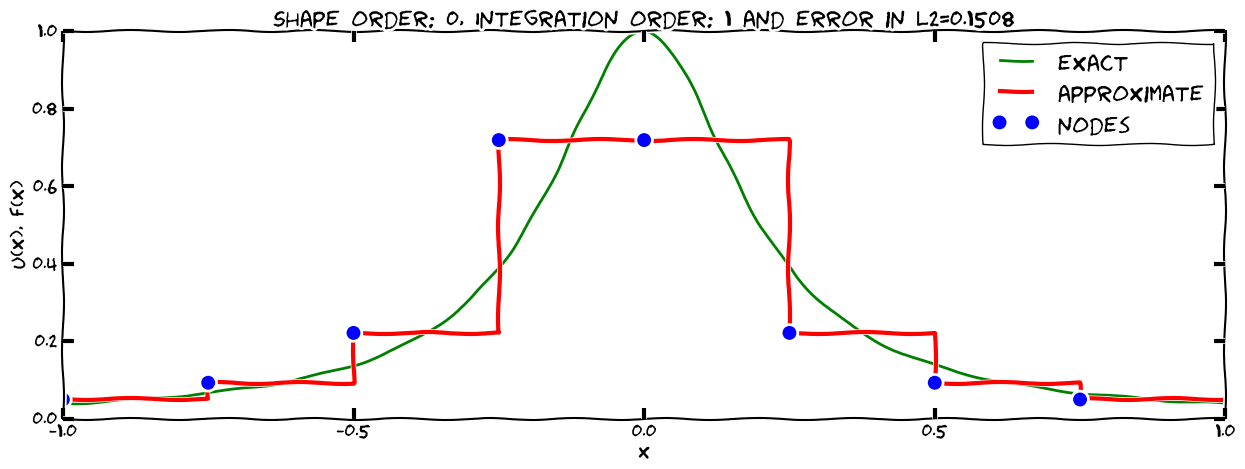

In [17]:
compare_plot(U, x_u, f, u, nodes, d=d, io=len(wp), eL2=eL2)

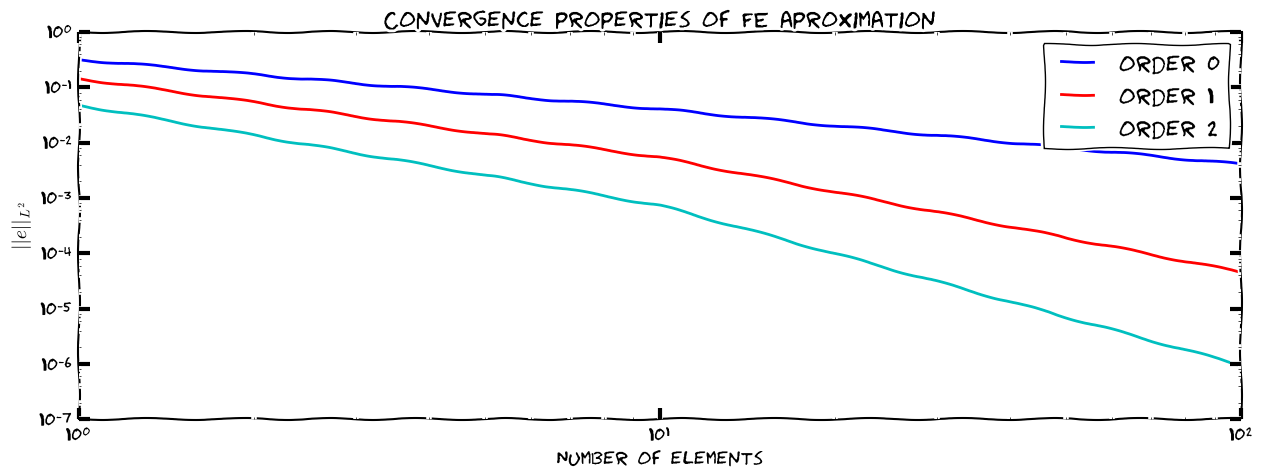

In [18]:
res = performance_test(f)
plot_test(res)